# Minor Project

### Importing the required libraries

In [3]:
import plaidml.keras
plaidml.keras.install_backend()

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
%matplotlib inline

### Loading the data using pandas

In [5]:
df = pd.read_csv("./labeled_data.csv")

In [6]:
df.drop(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
class    24783 non-null int64
tweet    24783 non-null object
dtypes: int64(1), object(1)
memory usage: 387.3+ KB


### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text

In [7]:
df = df.rename(index=str, columns={"class": "op", "tweet": "tweet"})
df.head()

,op,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


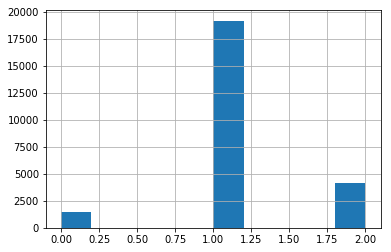

In [8]:
df['op'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [9]:
X = df.tweet
Y = df.op
le = LabelEncoder()
Y = le.fit_transform(Y)
print(Y)
Y = to_categorical(Y)
#Y = Y.reshape(-1,1)
print(Y)
print(Y[85])

[2 1 1 ... 1 1 2]
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[1. 0. 0.]


In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [11]:
max_words = 1000
max_len = 260
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### Defining the Model

In [12]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [13]:
model = RNN()
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

INFO:plaidml:Opening device "opencl_amd_capeverde.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 260)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 260, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                 771       
__________

### Custom weight assignment due to class imbalance problem

In [14]:
class_weight = {0: 50.,
                1: 1.,
                2: 20.}

### Training the model

In [23]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, class_weight=class_weight)

Epoch 1/10


Unknown: device or resource busy: device or resource busy

In [20]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

### Evaluating the accuracy of the model

In [87]:
accr = model.evaluate(test_sequences_matrix,Y_test)

3718/3718 [==============================] - 30s 8ms/step


In [88]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.788
  Accuracy: 0.762


In [0]:
y_preds = model.predict(test_sequences_matrix)

In [90]:
Y_t = []
for i in Y_test:
  Y_t.append(np.argmax(i))
  
#print(Y_t)


Y_p = []

for i in y_preds:
  Y_p.append(np.argmax(i))
  
#print(Y_p)

  

[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 2, 

### Displaying the classfication summary

In [91]:
report = classification_report( Y_t, Y_p )
print(report)

             precision    recall  f1-score   support

          0       0.18      0.55      0.27       212
          1       0.97      0.74      0.84      2885
          2       0.68      0.94      0.79       621

avg / total       0.88      0.76      0.80      3718



### Analyzing the confusion matrix 

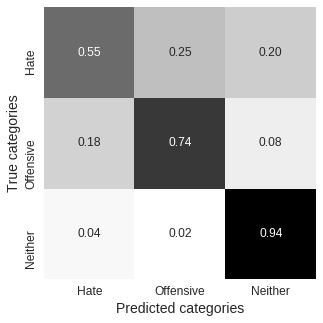

In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(Y_t,Y_p)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
